In [119]:
import numpy as np
import cv2
import os
import random
import torch
import torchvision.transforms as transforms
import torchvision.models as models
from matplotlib import pyplot as plt
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split

## 1. The Dataset

In [120]:
# Display leaf image
def get_image_display(image):
    fig = plt.figure(figsize=(10, 7.5))
    plt.imshow(image)
    plt.show()

In [121]:
# Ger 100 random images from specified folder
def get_images_from_class_folder(folder):
    image_list = os.listdir(folder)
    random_image_list = random.sample(image_list,100) 
    images = []
    for filename in random_image_list:
        img = cv2.imread(os.path.join(folder,filename))
        images.append(img)
    return images

100


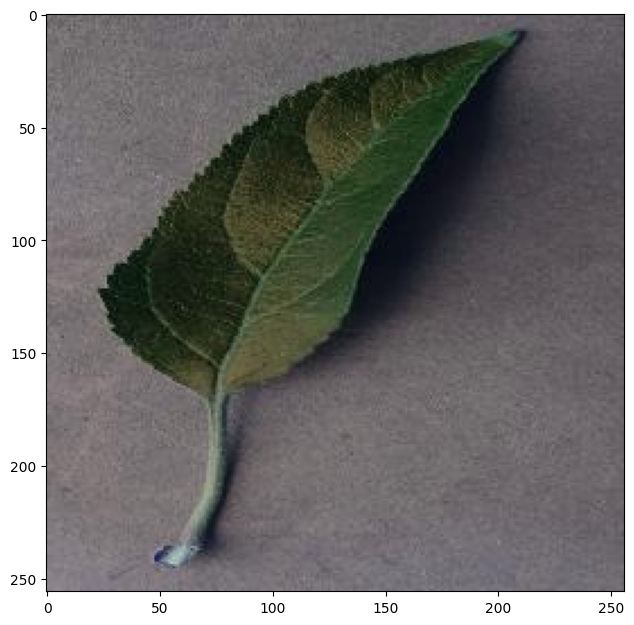

100


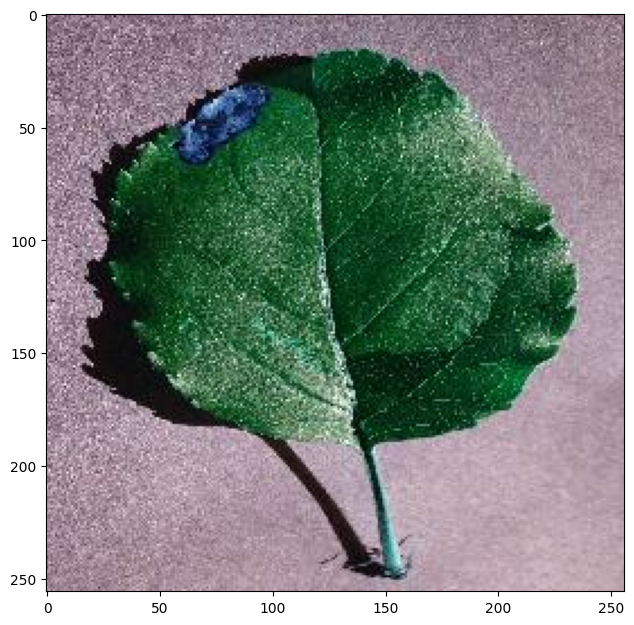

In [122]:
apple_healthy = 'Plant_leave_diseases_dataset_without_augmentation/Apple___healthy/'
apple_black_rot = 'Plant_leave_diseases_dataset_without_augmentation/Apple___Black_rot/'

# Get 100 healthy apple image and plot one of them
apple_healthy_image_list = get_images_from_class_folder(apple_healthy)
print(len(apple_healthy_image_list))
get_image_display(apple_healthy_image_list[0])

# Get 100 rotten apple image and plot one of them
apple_black_rot_image_list = get_images_from_class_folder(apple_black_rot)
print(len(apple_black_rot_image_list))
get_image_display(apple_black_rot_image_list[0])

## 2. Pretrained Models for Image Recognition

In [123]:
# Convert Images to Tensor
def transform_images_to_tensor(images):
    transformed_images = []    
    for image in images:
        transformed_image = transform(image)
        transformed_images.append(transformed_image)
    return transformed_images

In [124]:
# Defining the mapping function 
def mapping_function_by_model_features(model, x):
    return model(x)

In [125]:
# Transformation parameters
pretrained_size = 224
pretrained_means = [0.485, 0.456, 0.406]
pretrained_stds= [0.229, 0.224, 0.225]

# Define the transformation pipeline
transform = transforms.Compose([
    transforms.ToPILImage(),                     
    transforms.Resize((pretrained_size, pretrained_size)),                
    transforms.ToTensor(),              
    transforms.Normalize(pretrained_means,   
                         pretrained_stds)
])

# Tensor transformations
healthy_transformed_images = transform_images_to_tensor(apple_healthy_image_list)    
rotten_transformed_images = transform_images_to_tensor(apple_black_rot_image_list)

# Convert the list of tensor to a single tensor with dimension [100, 3, 224, 224]
healthy_images_tensor = torch.stack(healthy_transformed_images)
rotten_images_tensor = torch.stack(rotten_transformed_images)

In [126]:
# Load the VGG-16 network without batch normalization
model = models.vgg16(pretrained=True)
print("Before selecting model.features : ", model)

# Getting the model.features and discarding classifier part
model = model.features
model.eval()
print("After selecting model features : ", model)

Before selecting model.features :  VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size

## 3. Predicting Classes from Images

In [127]:
# Discriminant function calculation g(x)
def get_discriminant_score(results, difference_of_means_vector): 
    # Flatten the tensor results
    flat_results = results.view(len(results), -1)
    print("flat_results dimension : ", flat_results.shape)
    
    flat_difference_of_means_vector = torch.flatten(difference_of_means_vector)
    print("flat_difference_of_means_vector shape is : ", flat_difference_of_means_vector.shape)
    score = torch.matmul(flat_results, flat_difference_of_means_vector) # dot product
    return score

In [128]:
# All image data for both classes [200, 3, 224, 224]
X = torch.cat((healthy_images_tensor, rotten_images_tensor), 0)  

# All image label data for both classes [200, 3, 224, 224]
Y = torch.cat((torch.zeros(len(healthy_images_tensor)), torch.ones(len(rotten_images_tensor))), 0)    

# Train - Test Split of data and labels 
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3)

# Apply X_train in function mapping_function_by_model_features
results = mapping_function_by_model_features(model, X_train)
print("results shape : ", results.shape)

# Compute the difference of mean vector
apple_healthy_class_mean = torch.mean(results[Y_train == 0], dim=0)
print("apple_healthy_class_mean shape : ", apple_healthy_class_mean.shape)

apple_rotten_class_mean = torch.mean(results[Y_train == 1], dim=0)
print("apple_rotten_class_mean shape : ", apple_rotten_class_mean.shape)

difference_of_means_between_two_classes = apple_rotten_class_mean - apple_healthy_class_mean
difference_of_means_vector=difference_of_means_between_two_classes/torch.norm(difference_of_means_between_two_classes)

print("difference_of_means_vector shape : ", difference_of_means_vector.shape)

# Call discriminant_function scores for each class
healthy_phi_x = mapping_function_by_model_features(model, X_train[Y_train == 0])
print("shape of healthy_phi_x : ", healthy_phi_x.shape)
gx_for_healthy_class=get_discriminant_score(healthy_phi_x, difference_of_means_vector)
print("gx_for_healthy_class shape is : ", gx_for_healthy_class.shape)

rotten_phi_x = mapping_function_by_model_features(model, X_train[Y_train == 1])
print("shape of rotten_phi_x : ", rotten_phi_x.shape)
gx_for_rotten_class=get_discriminant_score(rotten_phi_x, difference_of_means_vector)
print("gx_for_rotten_class shape is : ", gx_for_rotten_class.shape)

print("Discriminant Score for the heatlhy class: ", torch.mean(gx_for_healthy_class))
print("Discriminant Score for the rotten class: ", torch.mean(gx_for_rotten_class))


# Get prediction score
phi_x_test = mapping_function_by_model_features(model, X_test)
print("phi_x_test shape is : ", phi_x_test.shape)
predictions = get_discriminant_score(phi_x_test, difference_of_means_vector)
print("predictions shape is : ", predictions.shape )


# ROC score from sklearn metrics
roc = roc_auc_score(Y_test, predictions.detach().numpy())

# Printing the required parameters asked in project
count_healthy_train = 0
count_rotten_train = 0
count_healthy_test = 0
count_rotten_test = 0
for i in range(len(Y_train)):
    if(Y_train[i] == 0):
        count_healthy_train+=1
    else:
        count_rotten_train+=1
        
for i in range(len(Y_test)):
    if(Y_test[i] == 0):
        count_healthy_test+=1
    else:
        count_rotten_test+=1

print("\nSome important metrics")
print("------------------------------------------------------\n")        
print("ROC value: ", roc)
print("Number of samples in train set : ", len(Y_train))
print("Number of samples in test set : ", len(Y_test))
print("Number of samples in healthy train set : ", count_healthy_train)
print("Number of samples in rotten train set : ", count_rotten_train)
print("Number of samples in healthy test set : ", count_healthy_test)
print("Number of samples in rotten test set : ", count_rotten_test)

results shape :  torch.Size([140, 512, 7, 7])
apple_healthy_class_mean shape :  torch.Size([512, 7, 7])
apple_rotten_class_mean shape :  torch.Size([512, 7, 7])
difference_of_means_vector shape :  torch.Size([512, 7, 7])
shape of healthy_phi_x :  torch.Size([71, 512, 7, 7])
flat_results dimension :  torch.Size([71, 25088])
flat_difference_of_means_vector shape is :  torch.Size([25088])
gx_for_healthy_class shape is :  torch.Size([71])
shape of rotten_phi_x :  torch.Size([69, 512, 7, 7])
flat_results dimension :  torch.Size([69, 25088])
flat_difference_of_means_vector shape is :  torch.Size([25088])
gx_for_rotten_class shape is :  torch.Size([69])
Discriminant Score for the heatlhy class:  tensor(3.9104, grad_fn=<MeanBackward0>)
Discriminant Score for the rotten class:  tensor(47.8858, grad_fn=<MeanBackward0>)
phi_x_test shape is :  torch.Size([60, 512, 7, 7])
flat_results dimension :  torch.Size([60, 25088])
flat_difference_of_means_vector shape is :  torch.Size([25088])
predictions sh

## 4. Understanding the Image-Class Relation Pixel-Wise

### 4.1 Sensitivity Analysis

image shape :  (256, 256, 3)


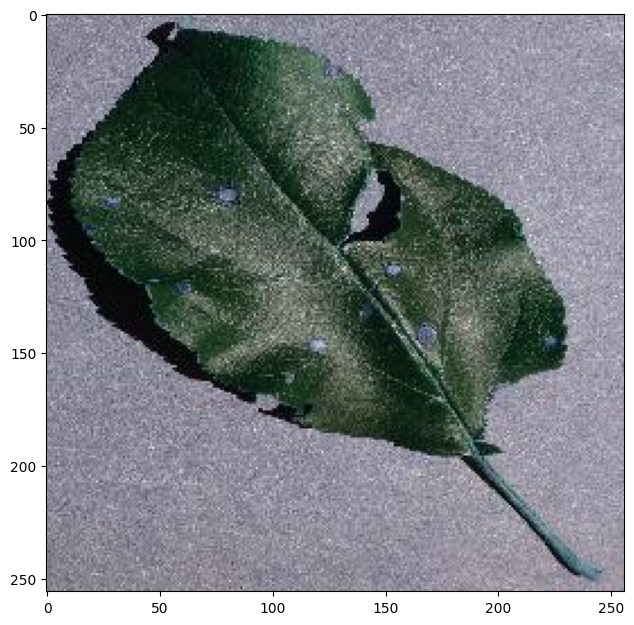

In [129]:
# Get one sample rotten image name for sensitivity analysis and plot it
one_sample_rotten_image_name = 'image (99).JPG' 
image = cv2.imread(os.path.join(apple_black_rot,one_sample_rotten_image_name))
print("image shape : ", image.shape)
fig = plt.figure(figsize=(10, 7.5))
plt.imshow(image)
plt.show()

In [130]:
# Gradient w.r.t score g(x) 
img = transform(image).unsqueeze(0)
print("img.shape is " , img.shape)
img.grad = None
img.requires_grad_(True)
features = mapping_function_by_model_features(model, img)
print("features.shape is : ", features.shape)
score = get_discriminant_score(features, difference_of_means_vector)
print("score is ", score)
score.backward()

img.shape is  torch.Size([1, 3, 224, 224])
features.shape is :  torch.Size([1, 512, 7, 7])
flat_results dimension :  torch.Size([1, 25088])
flat_difference_of_means_vector shape is :  torch.Size([25088])
score is  tensor([43.1977], grad_fn=<MvBackward0>)


img.grad shape is :  torch.Size([1, 3, 224, 224])
grads shape is :  torch.Size([3, 224, 224])
hm.shape shape is :  (224, 224)


/var/folders/pt/dm_fy_3519sdb_640xb7_fgm0000gn/T/ipykernel_44867/259121082.py:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('autumn').copy()


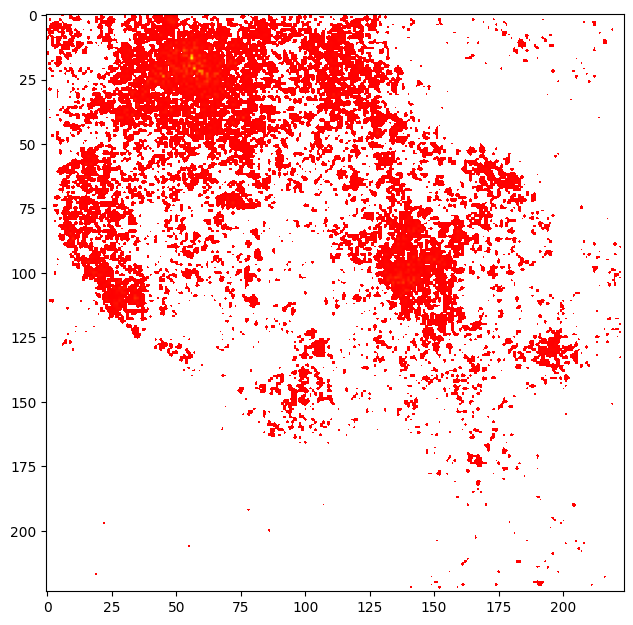

In [131]:
print("img.grad shape is : ", img.grad.shape)
grads = img.grad[0]
print("grads shape is : " , grads.shape)
hm = (torch.norm(grads, dim=0) ** 2).numpy()
print("hm.shape shape is : ", hm.shape)

# normalizing and displaying
hm = hm - np.min(hm) / np.max(hm) - np.min(hm)
cmap = plt.cm.get_cmap('autumn').copy()
cmap.set_under(color='white')
fig = plt.figure(figsize=(10, 7.5))
plt.imshow(hm, cmap=cmap, vmin=hm.mean())
plt.show()

### 4.2 More Robust Explanations

In [132]:
# Function to get smoothgrad based heatmap value (based on extra noise addition) 
def get_smoothgrad_hm(model, image, num_iterations, magnitude):   
    image.grad = None
    image.requires_grad = True
    # zeros matrix with same shape of input image
    smoothgrad_val = torch.zeros_like(image) 
    for _ in range(num_iterations):
        noise = torch.randn_like(image) * magnitude 
        noise_added_image = image + noise 
        op = mapping_function_by_model_features(model, noise_added_image) 
        discriminant_score = get_discriminant_score(op, difference_of_means_vector)
        gradients = torch.autograd.grad(discriminant_score, noise_added_image)
        gradient = gradients[0]
        smoothgrad_val += gradient
    smoothgrad_val = smoothgrad_val / num_iterations
    print("smoothgrad shape before squeeze :" , smoothgrad_val.shape)
    smoothgrad_val = smoothgrad_val.squeeze()
    print("smoothgrad shape after squeeze :" , smoothgrad_val.shape)
    hm = torch.norm(smoothgrad_val, dim=0).numpy()
    hm = hm - np.min(heatmap) / np.max(hm) - np.min(hm)
    return hm

flat_results dimension :  torch.Size([1, 25088])
flat_difference_of_means_vector shape is :  torch.Size([25088])
flat_results dimension :  torch.Size([1, 25088])
flat_difference_of_means_vector shape is :  torch.Size([25088])
flat_results dimension :  torch.Size([1, 25088])
flat_difference_of_means_vector shape is :  torch.Size([25088])
flat_results dimension :  torch.Size([1, 25088])
flat_difference_of_means_vector shape is :  torch.Size([25088])
flat_results dimension :  torch.Size([1, 25088])
flat_difference_of_means_vector shape is :  torch.Size([25088])
flat_results dimension :  torch.Size([1, 25088])
flat_difference_of_means_vector shape is :  torch.Size([25088])
flat_results dimension :  torch.Size([1, 25088])
flat_difference_of_means_vector shape is :  torch.Size([25088])
flat_results dimension :  torch.Size([1, 25088])
flat_difference_of_means_vector shape is :  torch.Size([25088])
flat_results dimension :  torch.Size([1, 25088])
flat_difference_of_means_vector shape is :  tor

/var/folders/pt/dm_fy_3519sdb_640xb7_fgm0000gn/T/ipykernel_44867/2115721542.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('autumn').copy()


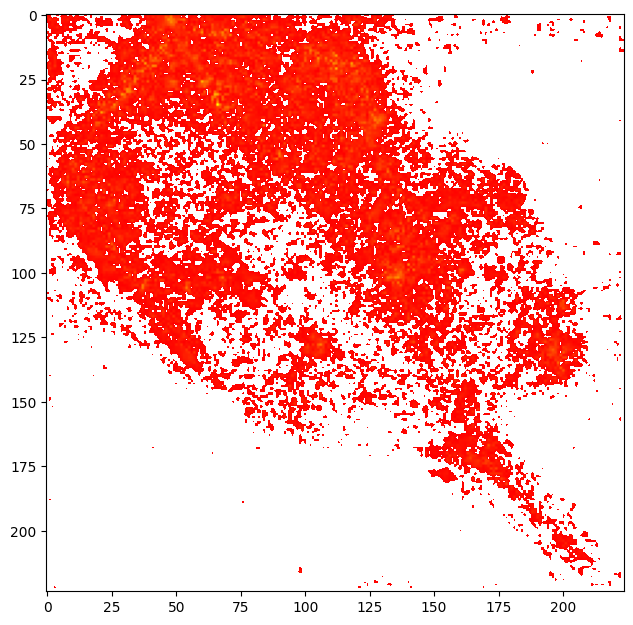

In [135]:
hm = get_smoothgrad_hm(model, img, 60, 0.2)
cmap = plt.cm.get_cmap('autumn').copy()
cmap.set_under(color='white')

# Display the sensitivity scores as a heatmap
fig = plt.figure(figsize=(10, 7.5))
plt.imshow(hm, cmap=cmap, vmin=hm.mean())
plt.show()